In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/ASUS/OneDrive/Desktop/ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()


In [ ]:
pip install pandas

In [ ]:
pip install mysql-connector-python

In [ ]:
pip install matplotlib

In [ ]:
pip install seaborn

In [5]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import mysql.connector


db = mysql.connector.connect (host = "localhost",
                               username = "root",
                               password = "1234",
                               database = "ecommerce")

cur = db.cursor()
                    

# List all unique cities where customers are located.


In [5]:
query = """ select distinct(customer_city) from customers """

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


 # Count the number of orders placed in 2017.

In [7]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are" , data[0][0]

('total orders placed in 2017 are', 135303)

# Find the total sales per category.

In [9]:
query = """ select products.product_category category, 
round(sum(payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])

df

,Category,Sales
0,perfumery,6080863.92
1,Furniture Decoration,17162116.70
2,telephony,5842584.61
3,Fashion Bags and Accessories,2617899.36
4,bed table bath,20550644.05
...,...,...
69,cds music dvds,14393.16
70,La Cuisine,34962.36
71,Fashion Children's Clothing,9428.04
72,PC Gamer,26093.16


# Calculate the percentage of orders that were paid in installments.


In [11]:
query = """select sum(case when payment_installments >= 1 then 1
else 0 end )/count(*)*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is" ,data [0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state

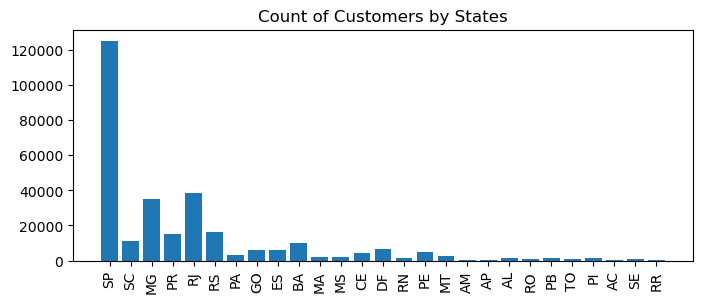

In [23]:
query = """select customer_state, count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["state", "customer_count" ])

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.title("Count of Customers by States")
plt.show()
                

# Calculate the number of orders per month in 2018.


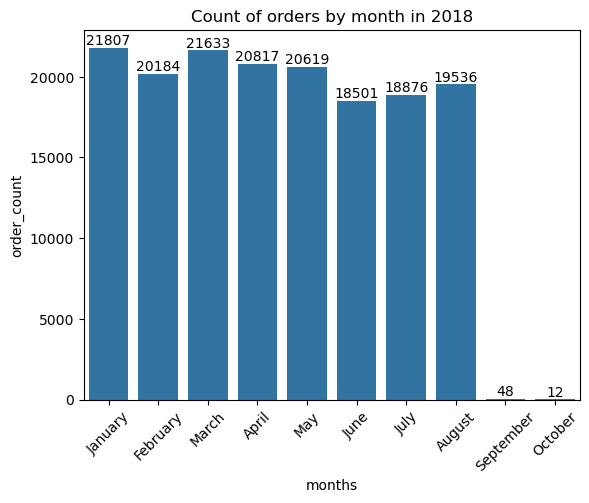

In [31]:
query = """select monthname(order_purchase_timestamp) months , count(order_id) order_count
from orders where year (order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ["months" , "order_count"])
o = ["January" , "February", "March","April","May","June","July","August","September","October"]

ax = sns.barplot( x = df ["months"], y = df["order_count"], data = df, order = o)

plt.xticks(rotation=45)

ax.bar_label(ax.containers[0])
plt.title("Count of orders by month in 2018")

plt.show()


# Find the average number of products per order, grouped by customer city.


In [13]:
query = """with count_per_order as 
(SELECT orders.order_id,orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
;


"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame( data, columns =["customer city ", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,42.00
1,celso ramos,39.00
2,datas,36.00
3,candido godoi,36.00
4,matias olimpio,30.00
5,cidelandia,24.00
6,curralinho,24.00
7,picarra,24.00
8,morro de sao paulo,24.00
9,teixeira soares,24.00
